In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

2025-02-27 18:35:47.469128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 18:35:47.650550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740652547.827780   12954 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740652547.857761   12954 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 18:35:48.026252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Background
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).
### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Data Inspection

In [3]:
# Import data
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df["label"].unique()

array([0, 1])

Based on the data inspection, the id represents image tag while the label is a boolean value indicating whether the image contains cancer or not. The images are 96x96 pixels in size and are stored in the .tif format.
Therefore, this problem involves a simple binary classification problem where the goal is to classify whether the image contains cancer or not.

To evaluate the model, the area under the ROC curve will be used.

## Exploratory Data Analysis

In [5]:
# Image sample size, for train/test data
print(len(os.listdir('histopathologic-cancer-detection/train')))
print(len(os.listdir('histopathologic-cancer-detection/test')))

220025
57458


In [6]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

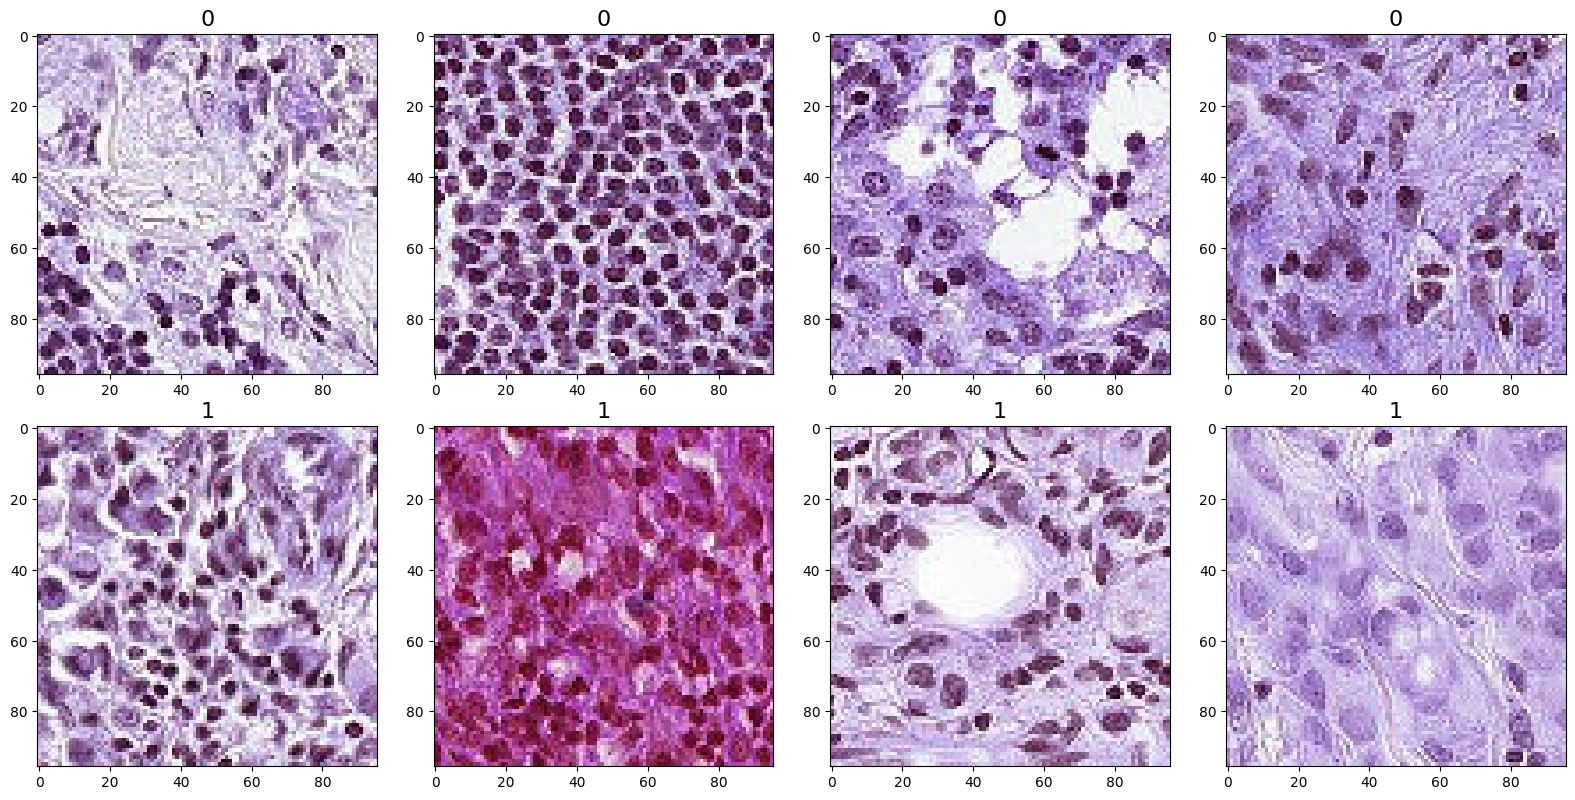

In [7]:
# Sample images
IMAGE_PATH = 'histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df, IMAGE_PATH)

In [8]:
# Check any missing data
print(df.isnull().sum())
# Check duplicated data
print(df.duplicated().sum())

id       0
label    0
dtype: int64
0


The data set for labels have no missing or duplicated values.

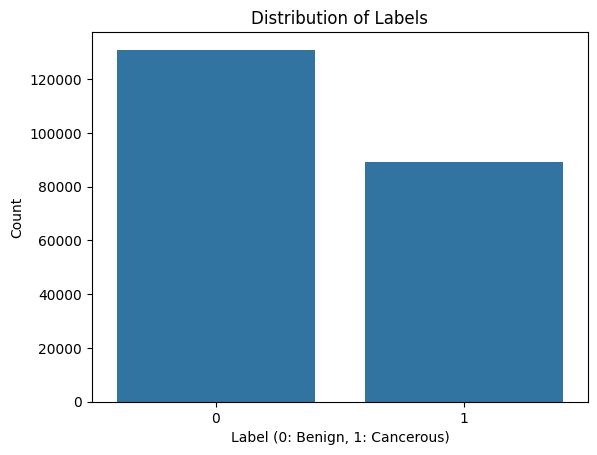

In [9]:
# Plot distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Benign, 1: Cancerous)')
plt.ylabel('Count')
plt.show()

From histogram, we can see there is no class imbalance in this dataset.

Based on the above, we can perform a simple binary classification model to classify whether the image contains cancer or not.

In [10]:
# Split data into train and test, by shuffling the data

df_0=df[df['label']==0].sample(80000, random_state=420)
df_1=df[df['label']==1].sample(80000, random_state=420)

df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df = shuffle(df)

df['label'].value_counts()

label
1    80000
0    80000
Name: count, dtype: int64

In [11]:
df_train, df_val = train_test_split(df, test_size=0.20, random_state=420, stratify=df['label'])

print(df_train.shape)
print(df_val.shape)

(128000, 2)
(32000, 2)


In [12]:
df.head()

,id,label
129662,3bc4b45fdfc6205036ed5034721507f361c45dc2,1
72541,48866bca5be173b30217e231a592c720489af6a7,0
60515,e4625bc638bc8d569432c127285a88e48b4e7423,0
159238,14ffd8c6c9149d784c27499135abe08078d20131,1
100590,209ec87f15905f30b70c8695908b68fcd366f551,1


In [13]:
df.set_index('id', inplace=True)

## Model Architecture

The model architecture will be a simple CNN model with the following layers:
- Conv2D layer with 32 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Conv2D layer with 64 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Conv2D layer with 128 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Flatten layer
- Dense layer with 128 units and ReLU activation function
- Dense layer with 1 unit and sigmoid activation function

The model will be compiled with the binary crossentropy loss function and the Adam optimizer.


In [14]:
IMAGE_SIZE=96
IMAGE_CHANNELS=3

def cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

model = cnn_model()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740652552.697973   12954 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Image Preparation

Created directory for image data for classifying whether the image contains cancer or not. Transfer images into them.

In [15]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    fname = image + '.tif'
    target = df.loc[image,'label']
    if target == 1:
        label = 'true'
    if target == 0:
        label = 'false'
    
    src = os.path.join('histopathologic-cancer-detection/train', fname)
    dst = os.path.join('histopathologic-cancer-detection/train_dir/', label, fname)

    shutil.copyfile(src, dst)

for image in val_list:
    fname = image + '.tif'
    target = df.loc[image,'label']
    if target == 1:
        label = 'true'
    if target == 0:
        label = 'false'
    src = os.path.join('histopathologic-cancer-detection/train', fname)
    dst = os.path.join('histopathologic-cancer-detection/val_dir/', label, fname)

    shutil.copyfile(src, dst)

In [16]:
# Check how many images are in the train_dir
print(len(os.listdir('histopathologic-cancer-detection/train_dir/true')))
print(len(os.listdir('histopathologic-cancer-detection/train_dir/false')))
print(len(os.listdir('histopathologic-cancer-detection/val_dir/true')))
print(len(os.listdir('histopathologic-cancer-detection/val_dir/false')))

64000
64000
16000
16000


In [17]:
train_path = 'histopathologic-cancer-detection/train_dir'
valid_path = 'histopathologic-cancer-detection/val_dir'
test_path = 'histopathologic-cancer-detection/test'
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [18]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 128000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.


## Model Training

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,034 (6.61 MB)

 Trainable params: 1,732,034 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
val_gen.class_indices

{'false': 0, 'true': 1}

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740652636.746805   13045 service.cc:148] XLA service 0x7f8af800dee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740652636.748085   13045 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-27 18:37:16.811564: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740652637.049515   13045 cuda_dnn.cc:529] Loaded cuDNN version 90300


   18/12800 ━━━━━━━━━━━━━━━━━━━━ 2:06 10ms/step - accuracy: 0.4649 - loss: 0.7808

I0000 00:00:1740652640.312576   13045 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12800/12800 ━━━━━━━━━━━━━━━━━━━━ 145s 11ms/step - accuracy: 0.7763 - loss: 0.4848 - val_accuracy: 0.8428 - val_loss: 0.3660
Epoch 2/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.8421 - loss: 0.3691 - val_accuracy: 0.8477 - val_loss: 0.3537
Epoch 3/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 139s 11ms/step - accuracy: 0.8494 - loss: 0.3549 - val_accuracy: 0.8543 - val_loss: 0.3475
Epoch 4/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 138s 11ms/step - accuracy: 0.8568 - loss: 0.3380 - val_accuracy: 0.8505 - val_loss: 0.3452
Epoch 5/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 135s 11ms/step - accuracy: 0.8602 - loss: 0.3346 - val_accuracy: 0.8610 - val_loss: 0.3235
Epoch 6/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 135s 11ms/step - accuracy: 0.8599 - loss: 0.3332 - val_accuracy: 0.8754 - val_loss: 0.3029
Epoch 7/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 135s 11ms/step - accuracy: 0.8630 - loss: 0.3261 - val_accuracy: 0.8651 - val_loss: 0.3215
Epoch 8/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 136s 11ms/step - accur

## Model Evaluation

In [23]:
model.metrics_names

['loss', 'compile_metrics']

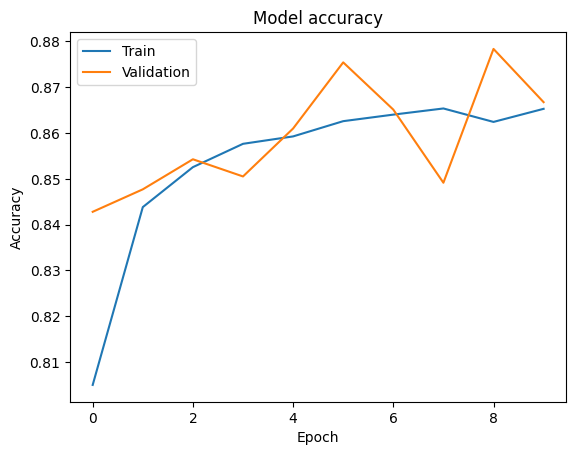

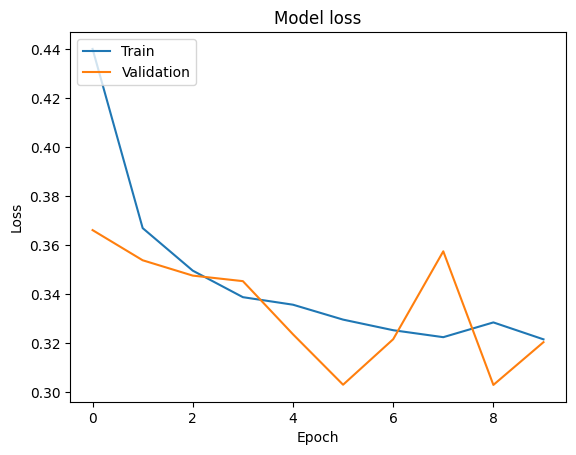

In [24]:
# Evaluation Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

From the model accuracy and model loss plot, we can see that the model is performing well on the training data. With increasing epochs, the model accuracy is increasing and the model loss is decreasing. 

However, at higher epoch for validation data, the line is fluctuating. This indicates that the model is at slight risk of overfitting.

In [ ]:
# Prediction

predictions = model.predict(test_gen, steps=len(df_val), verbose=1)
df_preds = pd.DataFrame(predictions, columns=['false', 'true'])
y_true = test_gen.classes
y_pred = df_preds['true']
y_pred

32000/32000 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step


0        0.017126
1        0.000944
2        0.075206
3        0.005952
4        0.477747
           ...   
31995    0.999655
31996    1.000000
31997    1.000000
31998    0.216093
31999    0.129716
Name: true, Length: 32000, dtype: float32

In [26]:
roc_auc_score(y_true, y_pred)

np.float64(0.9434543964843751)

A 94% score was achieved on the test set. The model was able to classify whether the image contains cancer or not with a high accuracy.

In [35]:
confusion_matrix(test_gen.classes, predictions.argmax(axis=1))

array([[13419,  2581],
       [ 1684, 14316]])

<Axes: >

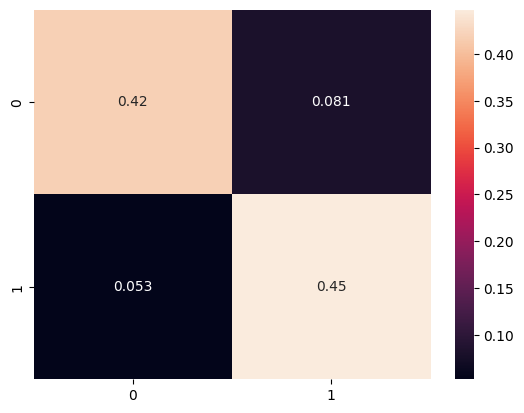

In [36]:
sns.heatmap(confusion_matrix(test_gen.classes, predictions.argmax(axis=1))/len(predictions), annot=True)